In [1]:
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy import sparse, stats
from sklearn.model_selection import KFold

from pynba import possessions_from_file, use_blackontrans_style

%load_ext pyinstrument

use_blackontrans_style()
league = "nba"
years = [2018, 2019, 2020, 2021, 2022]
season_type = "Regular Season"

possessions = pd.concat([possessions_from_file(league, year, season_type) for year in years])
nba_player_ids = pd.read_csv("/home/jupyter/nba/data/NBA_Player_IDs.csv", encoding_errors="ignore")
player_id_mapping = {
    int(player_id): player_name
    for player_name, player_id
    in zip(nba_player_ids["NBAName"], nba_player_ids["NBAID"])
    if not pd.isna(player_id)
}

In [2]:
POSS_COLS = [
    "off_player0", "off_player1", "off_player2", "off_player3", "off_player4", 
    "def_player0", "def_player1", "def_player2", "def_player3", "def_player4",
    "points_scored", "possession_num"
]


def calc_rapm(possessions, prior):
    var = _calc_variance(possessions)
    stints = _calc_stints(possessions)
    player_ids = _calc_player_ids(stints)
    n_players = player_ids.shape[0]
    X = _calc_X(stints, player_ids, n_players)
    w = _calc_w(stints)
    XT_W = _calc_XT_W(X, w)
    y = _calc_y(stints)
    G = _calc_G(X, var, prior)
    A, b = _calc_A_b(X, XT_W, G, y)
    x = _solve_for_x(A, b)
    
    rapm, off_rapm, def_rapm = _calc_rapm(x, n_players)
    rapm_std, off_rapm_std, def_rapm_std = _calc_stds(X, x, y, w, A, n_players)
    off_poss, def_poss, raw_pm, off_raw_pm, def_raw_pm = _calc_raw_stats(XT_W, b, n_players)
    names = _calc_names(player_ids)
    return pd.DataFrame({
        "name": names,
        "rapm": rapm,
        "off_rapm": off_rapm,
        "def_rapm": def_rapm,
        "rapm_std": rapm_std,
        "off_rapm_std": off_rapm_std,
        "def_rapm_std": def_rapm_std,
        "off_poss": off_poss,
        "def_poss": def_poss,
        "raw_pm": raw_pm,
        "off_raw_pm": off_raw_pm,
        "def_raw_pm": def_raw_pm,
    }, index=player_ids)


def _calc_player_ids(stints):
    cols = [f"off_player{ind}" for ind in range(5)] + [f"def_player{ind}" for ind in range(5)]
    return np.unique(stints.loc[:, cols])


def _calc_stints(possessions):
    poss = possessions.loc[:, POSS_COLS]
    off_player_ids = poss[[f"off_player{ind}" for ind in range(5)]].to_numpy()
    off_player_ids.sort(1)
    poss["off_player_ids"] = [row.tobytes() for row in off_player_ids]
    def_player_ids = poss[[f"def_player{ind}" for ind in range(5)]].to_numpy()
    def_player_ids.sort(1)
    poss["def_player_ids"] = [row.tobytes() for row in def_player_ids]
    return poss.groupby(by=["off_player_ids", "def_player_ids"]).agg(
        {
            "off_player0": "first",
            "off_player1": "first",
            "off_player2": "first",
            "off_player3": "first",
            "off_player4": "first",
            "def_player0": "first",
            "def_player1": "first",
            "def_player2": "first",
            "def_player3": "first",
            "def_player4": "first",
            "points_scored": "sum",
            "possession_num": "count",
        }
    ).reset_index()


def _calc_X(stints, player_ids, n_players):
    off_player_ids = stints.loc[:, [f"off_player{ind}" for ind in range(5)]].to_numpy()
    def_player_ids = stints.loc[:, [f"def_player{ind}" for ind in range(5)]].to_numpy()
    n_stints = stints.shape[0]

    X = sparse.lil_matrix((2 * n_players, n_stints))
    for ind, player_id in enumerate(player_ids):
        X[ind, :] = (player_id == off_player_ids).any(1)
        X[n_players + ind, :] = (player_id == def_player_ids).any(1)

    return X.T.tocsr().astype("float64")


def _calc_y(stints):
    mu = stints["points_scored"].sum() / stints["possession_num"].sum()
    y = (stints["points_scored"] / stints["possession_num"] - mu) * 100
    return y.to_numpy().astype("float64")


def _calc_w(stints):
    return stints["possession_num"].to_numpy().astype("float64").reshape(-1, 1)


def _calc_XT_W(X, w):
    return X.multiply(w).T.tocsr()


def _calc_G(X, var, prior):
    return sparse.diags([var / prior ** 2] * X.shape[1])


def _calc_A_b(X, XT_W, G, y):
    A = XT_W.dot(X) + G
    b = XT_W.dot(y)
    return A, b


def _calc_variance(possessions):
    counts = possessions["points_scored"].value_counts()
    p = counts / possessions.shape[0]
    eff = counts.index * 100
    return ((eff ** 2) * p).sum() - (eff * p).sum() ** 2


def _solve_for_x(A, b):
    return sparse.linalg.spsolve(A, b)


def _calc_rapm(x, n_players):
    off_rapm, def_rapm = x[:n_players], -x[n_players:]
    rapm = off_rapm + def_rapm
    return rapm, off_rapm, def_rapm


def _calc_stds(X, x, y, w, A, n_players):
    r = y - X.dot(x)
    rss = (r * w.reshape(-1)).dot(r)
    sigma2 = rss / (X.shape[0] - X.shape[1])
    cov_x = sigma2 * sparse.linalg.inv(A.tocsc())
    x_var = cov_x.diagonal()
    off_def_cov = cov_x.diagonal(n_players)
    off_rapm_var, def_rapm_var = x_var[:n_players], x_var[n_players:]
    rapm_var = off_rapm_var + def_rapm_var + 2 * off_def_cov
    return np.sqrt(rapm_var), np.sqrt(off_rapm_var), np.sqrt(def_rapm_var)


def _calc_raw_stats(XT_W, b, n_players):
    poss = np.asarray(XT_W.sum(1)).reshape(-1).astype(int)
    off_poss, def_poss = poss[:n_players], poss[n_players:]
    raw_pms = b / poss
    off_raw_pm, def_raw_pm = raw_pms[:n_players], -raw_pms[n_players:]
    raw_pm = off_raw_pm + def_raw_pm
    return off_poss, def_poss, raw_pm, off_raw_pm, def_raw_pm


def _calc_names(player_ids):
    return [player_id_mapping.get(player_id, "n/a") for player_id in player_ids]

## Calculating RAPM

In [3]:
prior = 2
%pyinstrument  rapm = calc_rapm(possessions, prior)
rapm.describe()

_     ._   __/__   _ _  _  _ _/_   Recorded: 04:14:55  Samples:  7075
 /_//_/// /_\ / //_// / //_'/ //     Duration: 29.460    CPU time: 48.228
/   _/                      v4.1.1

Program: /home/jupyter/.venv/lib/python3.8/site-packages/ipykernel_launcher.py -f /home/jupyter/.local/share/jupyter/runtime/kernel-aaf02d36-3676-4611-ae10-0f85fb464a16.json

29.459 <module>  ../../../tmp/ipykernel_806/1326332489.py:2
`- 29.453 calc_rapm  ../../../tmp/ipykernel_806/2303839804.py:8
   |- 17.783 _calc_X  ../../../tmp/ipykernel_806/2303839804.py:72
   |  |- 16.546 __setitem__  scipy/sparse/lil.py:323
   |  |     [93 frames hidden]  scipy, <built-in>, <__array_function_...
   |  |        14.591 lil_fancy_set  <built-in>:0
   |  `- 1.009 __getattr__  scipy/sparse/base.py:673
   |        [23 frames hidden]  scipy, <built-in>
   |- 7.922 _calc_stds  ../../../tmp/ipykernel_806/2303839804.py:126
   |  `- 7.896 inv  scipy/sparse/linalg/matfuncs.py:33
   |        [46 frames hidden]  scipy, <built-in>, numpy, <__array_fu...
   |           6.519 SuperLU.solve  <built-in>:0
   |- 2.120 _calc_stints  ../../../tmp/ipykernel_806/2303839804.py:46
   |  |- 1.114 aggregate  pandas/core/groupby/generic.py:964
   |  |     [129 frames hidden]  pandas, <built-in>, numpy, <__array_f...
   |  |- 0.332 <listcomp>  ../../../tmp/ipykernel_806/2303839804.py:53
   |  `- 0.319 <listcomp>  ../../../tmp/ipykernel_806/2303839804.py:50
   `- 1.229 _solve_for_x  ../../../tmp/ipykernel_806/2303839804.py:116
      `- 1.229 spsolve  scipy/sparse/linalg/dsolve/linsolve.py:91
            [7 frames hidden]  scipy, <built-in>

,rapm,off_rapm,def_rapm,rapm_std,off_rapm_std,def_rapm_std,off_poss,def_poss,raw_pm,off_raw_pm,def_raw_pm
count,9.720000e+02,972.000000,972.000000,972.000000,972.000000,972.000000,972.000000,972.000000,972.000000,972.000000,972.000000
mean,-2.678424e-14,-0.200549,0.200549,2.173355,1.537217,1.537351,5278.461934,5278.461934,-3.529364,-4.966200,1.436837
std,1.743393e+00,1.320555,1.085453,0.515586,0.364229,0.364195,6071.028038,6073.167320,15.341531,12.361421,12.751026
min,-5.423809e+00,-4.510434,-4.203621,1.280386,0.902754,0.903202,1.000000,1.000000,-148.214286,-109.259131,-90.740869
25%,-9.453886e-01,-0.925495,-0.369529,1.666109,1.179628,1.179543,356.000000,357.000000,-6.905084,-7.022481,-2.019029
50%,-9.432753e-02,-0.225165,0.097511,2.200807,1.555606,1.557069,2627.000000,2617.500000,-1.739664,-2.585172,0.184148
75%,7.421053e-01,0.307701,0.680266,2.699780,1.909670,1.908975,8630.750000,8639.250000,1.880864,0.743470,2.859159
max,8.223643e+00,6.539557,5.115806,2.828892,2.000329,2.000329,24212.000000,24241.000000,85.000000,32.846132,109.259131


## Scoring priors using cross-validation

We calculate X once and then split it since ~80% of the time to calculate RAPM is taken up by that task.

In [4]:
def score_rapm(possessions, priors):
    var = _calc_variance(possessions)
    stints = _calc_stints(possessions)
    player_ids = _calc_player_ids(stints)
    n_players = player_ids.shape[0]
    X = _calc_X(stints, player_ids, n_players)
    w = _calc_w(stints)
    XT_W = _calc_XT_W(X, w)
    y = _calc_y(stints)
    std = _calc_resid_std(var, stints)
    return {prior: _score_rapm(X, XT_W, y, std, var, prior) for prior in priors}


def _calc_resid_std(var, stints):
    return np.sqrt(var / stints["possession_num"])


def _score_rapm(X, XT_W, y, std, var, prior):
    logpdf = 0
    for train_index, test_index in KFold(n_splits=10).split(X):
        X_train = X[train_index]
        XT_W_train = XT_W[:, train_index]
        y_train = y[train_index]
        X_test = X[test_index]
        y_test = y[test_index]
        std_test = std[test_index]
        G_train = _calc_G(X_train, var, prior)
        A_train, b_train = _calc_A_b(X_train, XT_W_train, G_train, y_train)
        x = _solve_for_x(A_train, b_train)
        normalized_test_err = (y_test - X_test.dot(x)) / std_test
        logpdf += stats.norm.logpdf(normalized_test_err).sum()
    return logpdf

In [5]:
priors = np.linspace(1, 3, 9)
%pyinstrument scores = score_rapm(possessions, priors=priors)
scores

_     ._   __/__   _ _  _  _ _/_   Recorded: 04:15:25  Samples:  6816
 /_//_/// /_\ / //_// / //_'/ //     Duration: 167.021   CPU time: 1089.772
/   _/                      v4.1.1

Program: /home/jupyter/.venv/lib/python3.8/site-packages/ipykernel_launcher.py -f /home/jupyter/.local/share/jupyter/runtime/kernel-aaf02d36-3676-4611-ae10-0f85fb464a16.json

167.021 <module>  ../../../tmp/ipykernel_806/1739885309.py:2
`- 167.003 score_rapm  ../../../tmp/ipykernel_806/1171476472.py:1
   |- 147.228 <dictcomp>  ../../../tmp/ipykernel_806/1171476472.py:11
   |  `- 147.228 _score_rapm  ../../../tmp/ipykernel_806/1171476472.py:18
   |     |- 122.433 _solve_for_x  ../../../tmp/ipykernel_806/2303839804.py:116
   |     |  `- 122.433 spsolve  scipy/sparse/linalg/dsolve/linsolve.py:91
   |     |        [22 frames hidden]  scipy, <built-in>
   |     |           119.645 gssv  <built-in>:0
   |     |- 20.934 _calc_A_b  ../../../tmp/ipykernel_806/2303839804.py:103
   |     |  `- 20.566 dot  scipy/sparse/base.py:346
   |     |        [28 frames hidden]  scipy, <built-in>, <__array_function_...
   |     `- 3.370 __getitem__  scipy/sparse/_index.py:32
   |           [51 frames hidden]  scipy, <built-in>, <__array_function_...
   |- 17.549 _calc_X  ../../../tmp/ipykernel_806/2303839804.py:72
   |  `- 16.379 __setitem__  scipy/sparse/lil.py:323
   |        [87 frames hidden]  scipy, <built-in>, <__array_function_...
   `- 1.999 _calc_stints  ../../../tmp/ipykernel_806/2303839804.py:46

{1.0: -376065.324725994,
 1.25: -375979.91933742317,
 1.5: -375931.4117440137,
 1.75: -375908.0564757804,
 2.0: -375901.452792426,
 2.25: -375905.83432483755,
 2.5: -375917.32387550455,
 2.75: -375933.33995408734,
 3.0: -375952.1694235422}

## Finding the optimal prior by fitting scores to a quadratic

Can we save time by fitting the scores to a quadratic?

In [6]:
def find_best_prior(scores):
    priors = np.array(list(scores.keys()))
    X = np.array([priors ** 2, priors, np.ones(priors.shape[0])]).T
    y = np.array(list(scores.values()))
    res = np.linalg.lstsq(X, y, rcond=None)
    a, b, c = res[0]
    x_h = np.linspace(priors.min(), priors.max())
    y_h = a * x_h ** 2 + b * x_h + c
    return -b / (2 * a), x_h, y_h

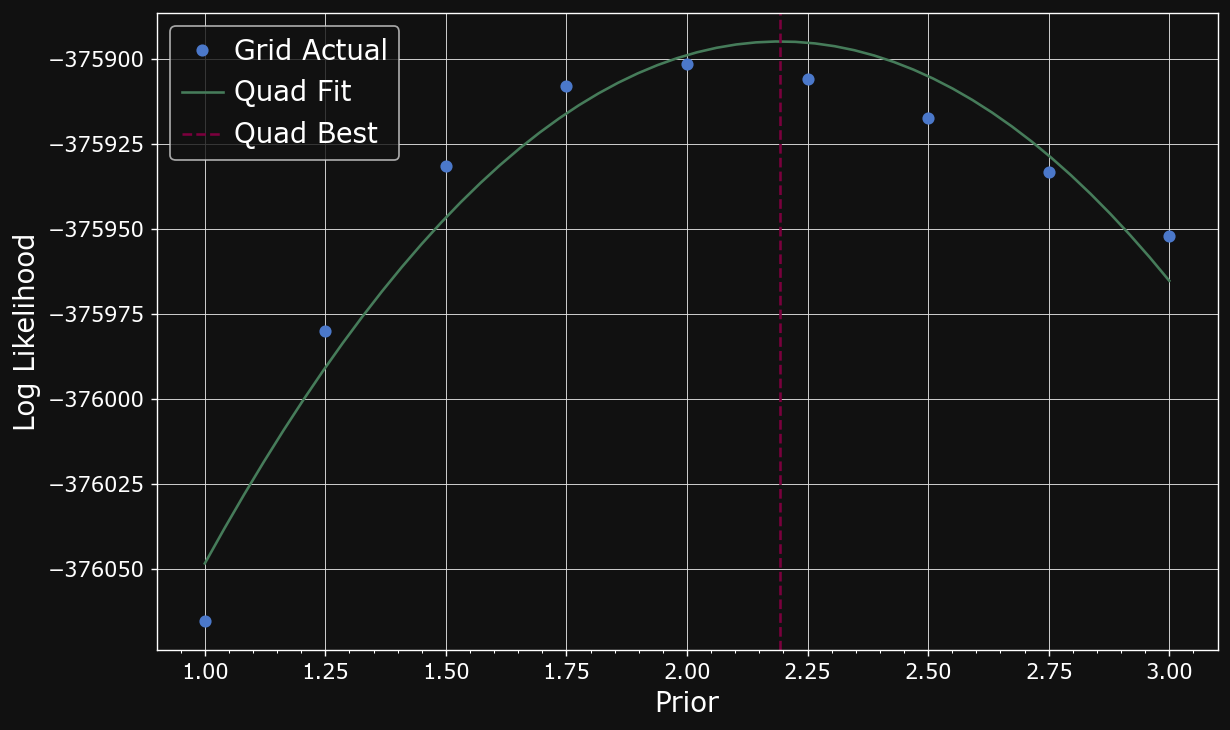

In [7]:
prior, x_h, y_h = find_best_prior(scores)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(scores.keys(), scores.values(), "o", label="Grid Actual")
ax.plot(x_h, y_h, label="Quad Fit")
ax.axvline(prior, ls="--", c="C2", label="Quad Best")
ax.set_xlabel("Prior")
ax.set_ylabel("Log Likelihood")
ax.legend();

## Optimizing the prior using pattern search

Cutting the search space in half takes 1.5 evaluations (we're assuming the search space is convex).

In [8]:
def _pattern_search(func, rounds, *args):
    bounds = np.array([[arg[0], arg[1]] for arg in args]).astype(float)
    x1 = bounds.mean(1)
    y1 = func(*x1)
    steps = np.diff(bounds, 1).reshape(-1) / 4
    history = [(tuple(x1), y1)]
    for _ in range(rounds):
        for ind, step in enumerate(steps):
            x0 = x1.copy()
            x0[ind] -= step
            y0 = func(*x0)
            history.append((tuple(x0), y0))
            if y0 > y1:
                bounds[ind, 1] = x1[ind]
                x1, y1 = x0, y0
                continue
            x2 = x1.copy()
            x2[ind] += step
            y2 = func(*x2)
            history.append((tuple(x2), y2))
            if y2 > y1:
                bounds[ind, 0] = x1[ind]
                x1, y1 = x2, y2
            else:
                bounds[ind, 0] = x0[ind]
                bounds[ind, 1] = x2[ind]
        steps /= 2
    return tuple(x1), y1, bounds, history


def optimize_rapm(possessions, rounds, prior_range):
    var = _calc_variance(possessions)
    stints = _calc_stints(possessions)
    player_ids = _calc_player_ids(stints)
    n_players = player_ids.shape[0]
    X = _calc_X(stints, player_ids, n_players)
    w = _calc_w(stints)
    XT_W = _calc_XT_W(X, w)
    y = _calc_y(stints)
    std = _calc_resid_std(var, stints)
    def objective(prior):
        return _score_rapm(X, XT_W, y, std, var, prior)
    return _pattern_search(objective, rounds, prior_range)

In [9]:
prior_range = (1, 3)
rounds = 5
%pyinstrument best_prior, lowest_score, best_range, history = optimize_rapm(possessions, rounds, prior_range)

_     ._   __/__   _ _  _  _ _/_   Recorded: 04:18:13  Samples:  7382
 /_//_/// /_\ / //_// / //_'/ //     Duration: 218.164   CPU time: 1444.983
/   _/                      v4.1.1

Program: /home/jupyter/.venv/lib/python3.8/site-packages/ipykernel_launcher.py -f /home/jupyter/.local/share/jupyter/runtime/kernel-aaf02d36-3676-4611-ae10-0f85fb464a16.json

218.164 <module>  ../../../tmp/ipykernel_806/1688433378.py:2
`- 218.154 optimize_rapm  ../../../tmp/ipykernel_806/2849488976.py:31
   |- 198.055 _pattern_search  ../../../tmp/ipykernel_806/2849488976.py:1
   |  `- 198.054 objective  ../../../tmp/ipykernel_806/2849488976.py:41
   |     `- 198.054 _score_rapm  ../../../tmp/ipykernel_806/1171476472.py:18
   |        |- 166.160 _solve_for_x  ../../../tmp/ipykernel_806/2303839804.py:116
   |        |  `- 166.160 spsolve  scipy/sparse/linalg/dsolve/linsolve.py:91
   |        |        [19 frames hidden]  scipy, <built-in>
   |        |           162.344 gssv  <built-in>:0
   |        |- 26.636 _calc_A_b  ../../../tmp/ipykernel_806/2303839804.py:103
   |        |  `- 26.131 dot  scipy/sparse/base.py:346
   |        |        [39 frames hidden]  scipy, <built-in>, <__array_function_...
   |        `- 4.580 __getitem__  scipy/sparse/_index.py:32
   |              [53 frames hidden]  scipy, <built-in>, <__array_function_...
   `- 17.790 _calc_X  ../../../tmp/ipykernel_806/2303839804.py:72
      `- 16.498 __setitem__  scipy/sparse/lil.py:323
            [97 frames hidden]  scipy, <built-in>, <__array_function_...

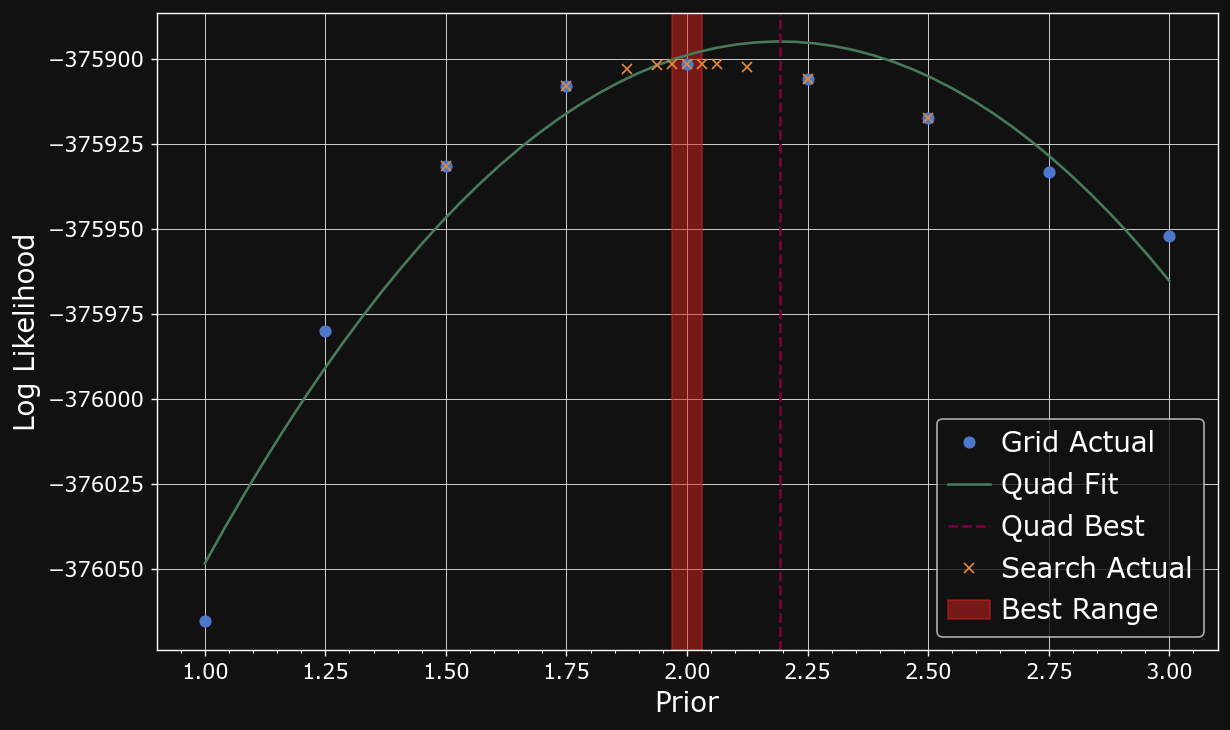

In [10]:
new_priors, new_scores = list(zip(*history))
new_priors = [prior[0] for prior in new_priors]

ax.plot(new_priors, new_scores, "C3x", label="Search Actual")
ax.axvspan(best_range[0, 0], best_range[0, 1], color="C4", alpha=0.5, label="Best Range")
ax.legend()
fig

,name,rapm,off_rapm,def_rapm,rapm_std,off_rapm_std,def_rapm_std,off_poss,def_poss,raw_pm,off_raw_pm,def_raw_pm
201939,Stephen Curry,8.223643,6.539557,1.684086,1.610233,1.138738,1.138860,15771,15827,10.473969,8.089166,2.384802
203507,Giannis Antetokounmpo,7.679790,2.703769,4.976020,1.416945,1.003251,1.003021,21116,21169,9.392965,4.697111,4.695855
101108,Chris Paul,7.113958,3.830106,3.283852,1.320301,0.935357,0.934385,18883,18949,8.438974,6.045640,2.393333
2544,LeBron James,6.574501,5.264882,1.309619,1.317080,0.933085,0.932855,20204,20229,4.360857,3.372031,0.988826
203081,Damian Lillard,6.475774,5.825950,0.649824,1.455443,1.032223,1.032399,23549,23547,4.623514,5.798833,-1.175319
203954,Joel Embiid,6.449322,2.102541,4.346781,1.475378,1.045482,1.045212,16532,16557,8.227216,3.461653,4.765563
203999,Nikola Jokic,6.412983,5.137863,1.275120,1.587607,1.124600,1.125997,21597,21630,6.075763,6.460645,-0.384882
201950,Jrue Holiday,6.237414,4.149146,2.088268,1.315769,0.931957,0.931912,21909,21929,5.078448,4.004824,1.073623
202695,Kawhi Leonard,6.229921,4.856655,1.373266,1.527883,1.081597,1.081375,12069,12070,10.730547,8.447390,2.283158
202331,Paul George,6.201151,2.556035,3.645116,1.381359,0.976323,0.976651,20642,20628,6.870208,3.695040,3.175168


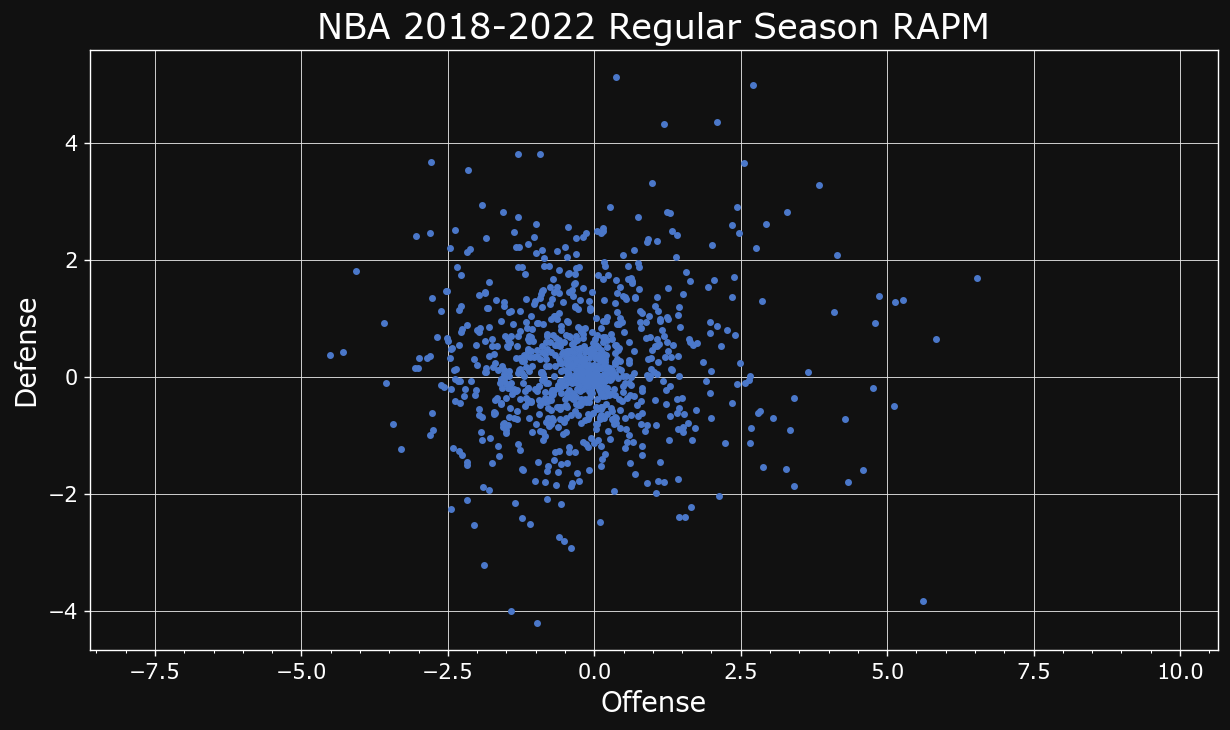

In [11]:
rapm = calc_rapm(possessions, best_prior[0])
rapm.sort_values(by="rapm", ascending=False).head(30)

In [ ]:
lim = max(np.ceil(rapm["off_rapm"].abs().max()), np.ceil(rapm["def_rapm"].abs().max()))
joint_grid = sns.jointplot(x=rapm["off_rapm"], y=rapm["def_rapm"], height=10, xlim=(-lim, lim), ylim=(-lim, lim), marker=".", edgecolor="C0");
joint_grid.ax_joint.set_xlabel("Offense")
joint_grid.ax_joint.set_ylabel("Defense")
joint_grid.ax_joint.set_title(f"{league.upper()} {min(years)}-{max(years)} {season_type} RAPM");